In [1]:
import os

# ustawienie katalogu roboczego
output_dir = r'G:\Mój dysk\...\EAP_NLP'
os.chdir(output_dir)

# sprawdzenie aktualnego katalogu roboczego
current_working_directory = os.getcwd()
print(f'Aktualny katalog roboczy: {current_working_directory}')

Aktualny katalog roboczy: G:\...\EAP_NLP


In [2]:
#Importy bibliotek

import os
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from afinn import Afinn
from statistics import mean, median
from collections import defaultdict
from nrclex import NRCLex
import gensim
from gensim import corpora
from wordcloud import WordCloud
sns.set_theme()

C:\Users\rosom\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rosom\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Utworzenie korpusu

DOC_PATTERN = r'document_\d+.txt'

corpus = PlaintextCorpusReader(
   current_working_directory + r'\Corpus',
    DOC_PATTERN)

In [4]:
def get_wordnet_pos(treebank_tag):
    """
    Funkcja mapuje tagi POS z NLTK na format używany przez WordNet
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Domyślnie jako rzeczownik

# Inicjalizacja lematyzatora
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    """
    Funkcja tokenizująca i lematyzująca tekst.
    """
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]
    return lemmatized_tokens

additional_irrelevant_words =str.split(""" may however one like long little great length could would might
among two first second upon us mr even much thus yet first every two within still never many without
although must nothing whole thing indeed""",' ')
stop_words = set(stopwords.words('english')+additional_irrelevant_words)

#Procesowanie korpusu: tokenizacja,lematyzacja, usunięcie stopwords
lemmatized_corpus = {}

for fileid in corpus.fileids():
    raw_text = corpus.raw(fileids=[fileid])
    lemmatized_tokens = tokenize_and_lemmatize(raw_text)
    filtered_tokens = [token for token in lemmatized_tokens if
                       token.lower() not in stop_words and 
                       token.isalpha() and
                       len(token) > 3]
    lemmatized_corpus[fileid] = filtered_tokens

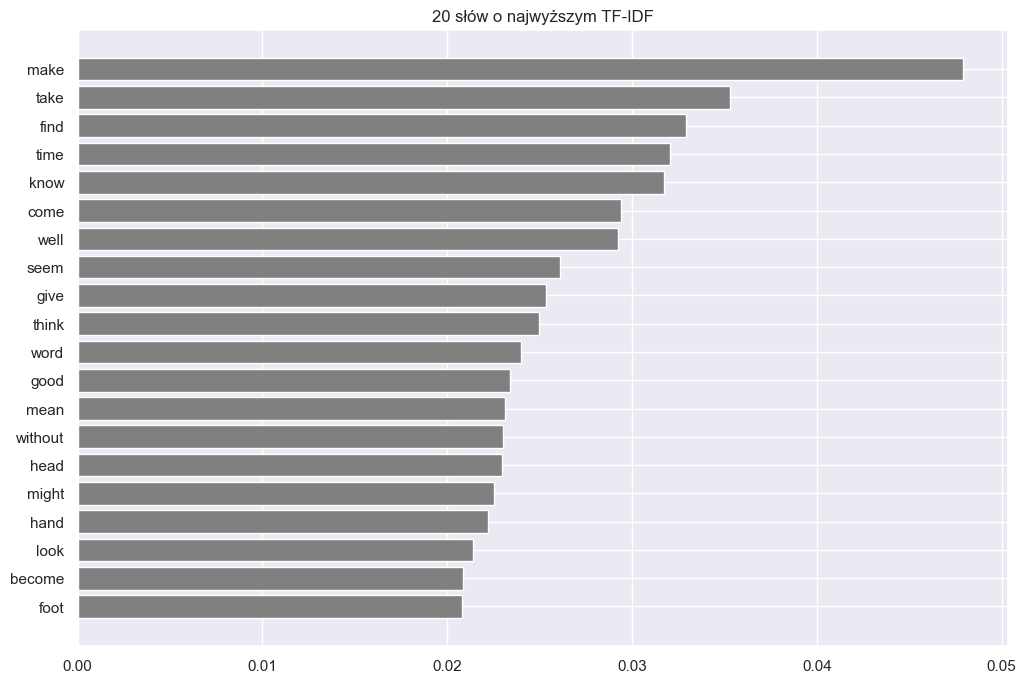

In [5]:
# Konwersja lematyzowanego korpusu na listę dokumentów (jako tekst)
documents = [' '.join(tokens) for tokens in lemmatized_corpus.values()]

# Obliczanie TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Średnia wartość TF-IDF dla każdego słowa
average_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), average_tfidf))

# Sortowanie słów według wartości TF-IDF i wybór 20 najwyższych
sorted_tfidf_scores = sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)
top_20_words = sorted_tfidf_scores[:20]

# Wykres
words, scores = zip(*top_20_words)
plt.figure(figsize=(12, 8))
plt.barh(words, scores, color='grey')
plt.title('20 słów o najwyższym TF-IDF')
plt.gca().invert_yaxis()
plt.show()

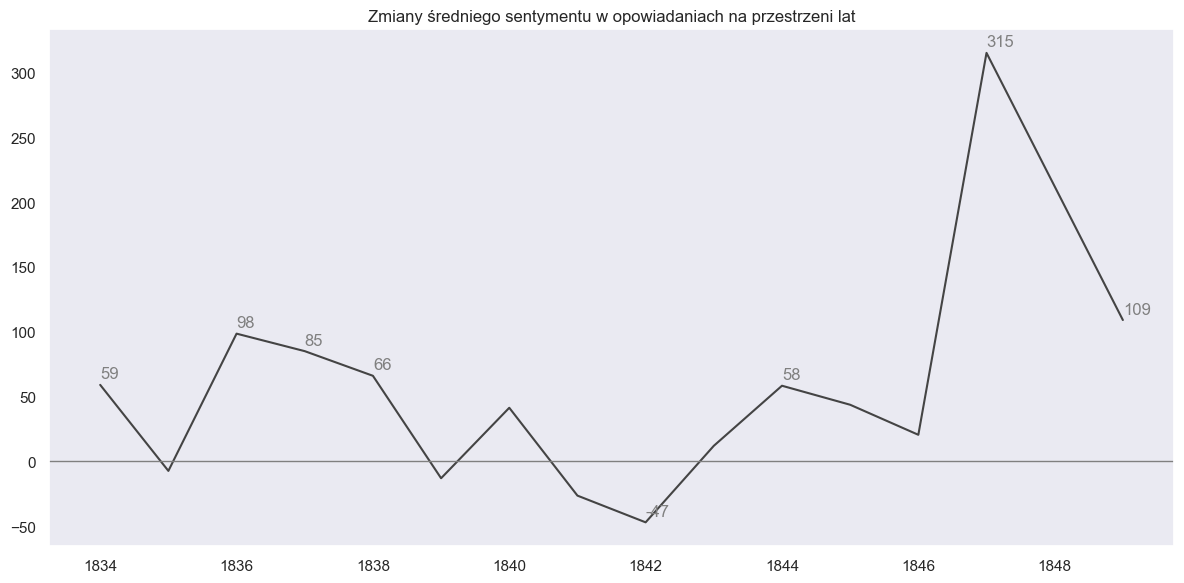

In [6]:
#Utworzenie słownika przechowującego sentyment i lata
sentiments_by_year = {}

# Ocena sentymentu każdego z dokumentów korzystając z modelu Afinn
afinn = Afinn()
for fileid in corpus.fileids():
    # Wyciągnięcie rok publikacji z metadanych
    text = corpus.raw(fileid)
    match = re.search(r'publication_date: (\w+ \d+)', text)
    if match:
        publication_date = match.group(1)
        year = int(publication_date.split()[-1])
        if year < 1834 or year > 1849:
            continue
        tokens = lemmatized_corpus[fileid]
        sentiment_score = afinn.score(' '.join(tokens))
        processed_tokens=[token.lower() for token in tokens if token.lower() not in stop_words]
        #Ocena sentymentu
        sentiment_score =  afinn.score(' '.join(lemmatized_corpus[fileid]))
        # Dodanie sentymentu do odpowiadającego roku
        if year not in sentiments_by_year:
            sentiments_by_year[year] = []
        sentiments_by_year[year].append(sentiment_score)

# Obliczenie średniego sentymentu dla każdego roku
years = sorted(sentiments_by_year.keys())
avg_sentiments = [np.mean(sentiments_by_year[year]) for year in years]

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(years, avg_sentiments, '#444444')

# Etykietowanie punktów na wykresie
for x, y in zip(years, avg_sentiments):
    if y > median(avg_sentiments) or y == min(avg_sentiments): #wyświetlenie tylko etykiet powyżej mediany i minimalnej
        plt.text(x=x, y=y+5, s='{:.0f}'.format(y), color='grey') 
plt.title('Zmiany średniego sentymentu w opowiadaniach na przestrzeni lat')
plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)
plt.grid(False)
plt.tight_layout()
plt.show()



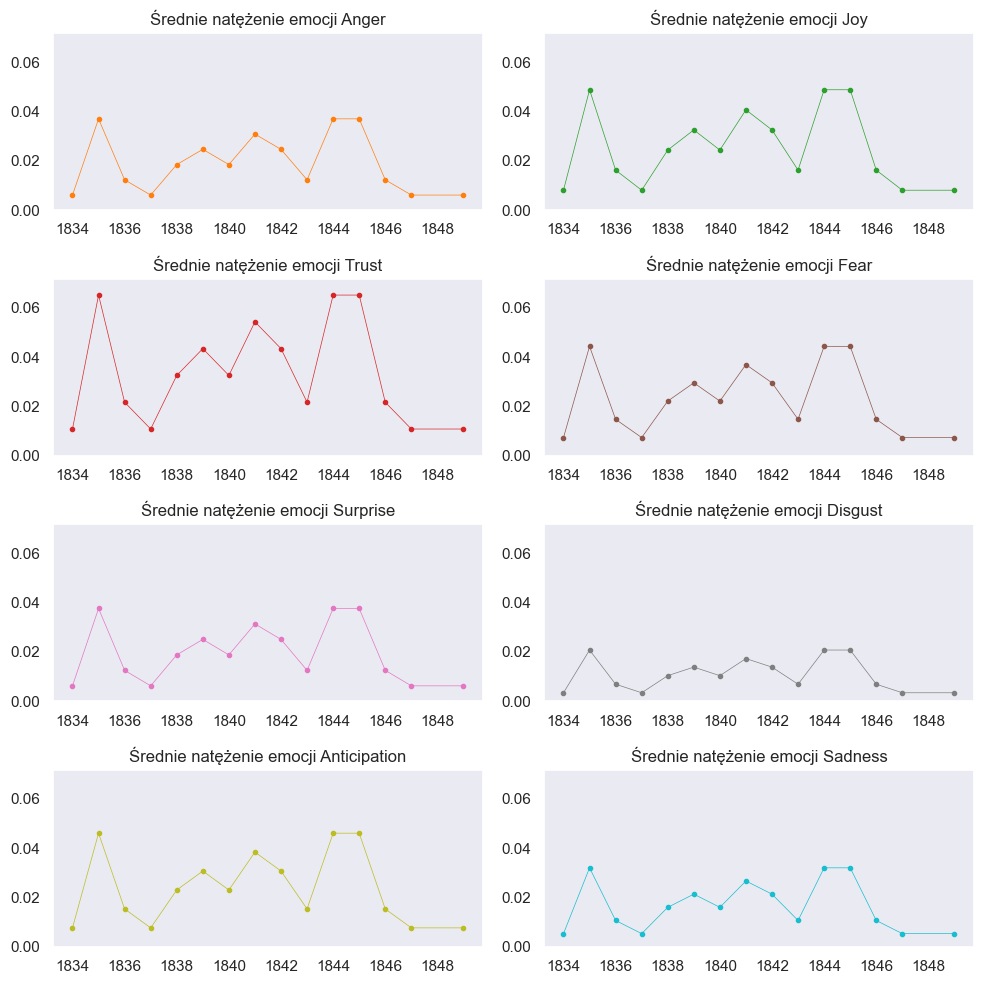

In [7]:
# Słownik do przechowywania proporcji emocji dla poszczególnych lat
emotions_by_year = defaultdict(lambda: defaultdict(int))

# Ocena sentymentu każdego dokumentu korzystając z modelu NRCLex
for fileid in corpus.fileids():
    # Wyciągnięcie roku publikacji z metadanych
    text = corpus.raw(fileid)
    match = re.search(r'publication_date: (\w+ \d+)', text)
    if match:
        publication_date = match.group(1)
        year = int(publication_date.split()[-1])
        if year < 1834 or year > 1849:
            continue    
        # Analiza emocji za pomocą NRCLex
        text = ' '.join(lemmatized_tokens)
        emotions = NRCLex(text).affect_frequencies
        # Sparowanie emocji i roku
        for emotion, score in emotions.items():
            emotions_by_year[year][emotion] += score

# Obliczenie średnich proporcje emocji dla każdego roku
years = sorted(emotions_by_year.keys())
avg_emotions = {year: {emotion: score / len(emotions_by_year[year]) for emotion, score in emotions.items()} for year, emotions in emotions_by_year.items()}

# Emocje do analizy
emotions_to_analyze = ['anger', 'joy', 'trust', 'fear', 'surprise', 'disgust', 'anticipation', 'sadness']

# Znalezienie max i min wartości emocji dla wspólnej skali
all_scores = [avg_emotions[year][emotion] for year in years for emotion in emotions_to_analyze]
y_min, y_max = min(all_scores), max(all_scores)
colors = plt.cm.get_cmap('tab10', len(emotions_to_analyze)+1)

# Tworzenie wykresów dla każdej emocji
plt.figure(figsize=(10, 10))
for i, emotion in enumerate(emotions_to_analyze, start=1):
    plt.subplot(4, 2, i)
    avg_scores = [avg_emotions[year][emotion] for year in years]
    plt.plot(years, avg_scores, marker='.', linestyle='-', label=emotion.capitalize(),color=colors(i),linewidth = 0.5)
    plt.title(f'Średnie natężenie emocji {emotion.capitalize()}')
    plt.ylim(0, 1.1*y_max)
    plt.grid(False)

plt.tight_layout()
plt.show()

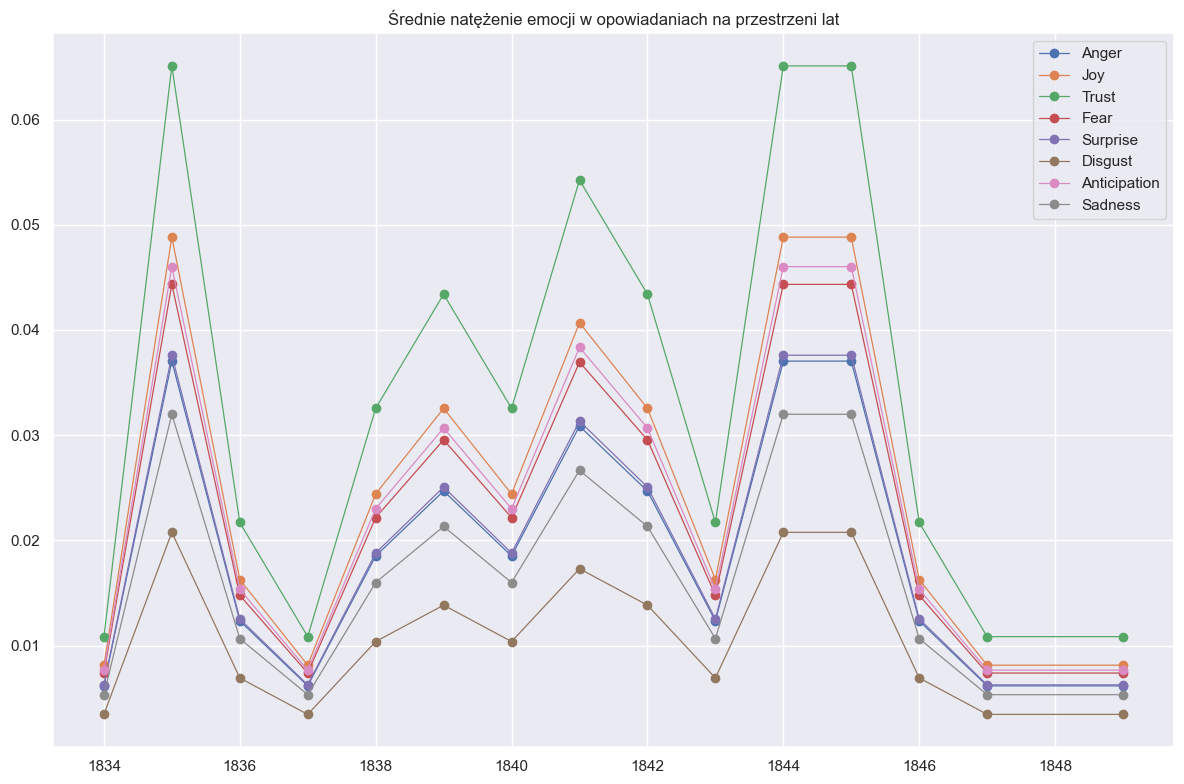

In [8]:
# Tworzenie wspólnego wykresu dla wszystkich emocji
plt.figure(figsize=(12, 8))

for emotion in emotions_to_analyze:
    avg_scores = [avg_emotions[year].get(emotion, 0) for year in years]
    plt.plot(years, avg_scores, marker='o', linestyle='-', label=emotion.capitalize(),linewidth = 0.9)

plt.title('Średnie natężenie emocji w opowiadaniach na przestrzeni lat')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

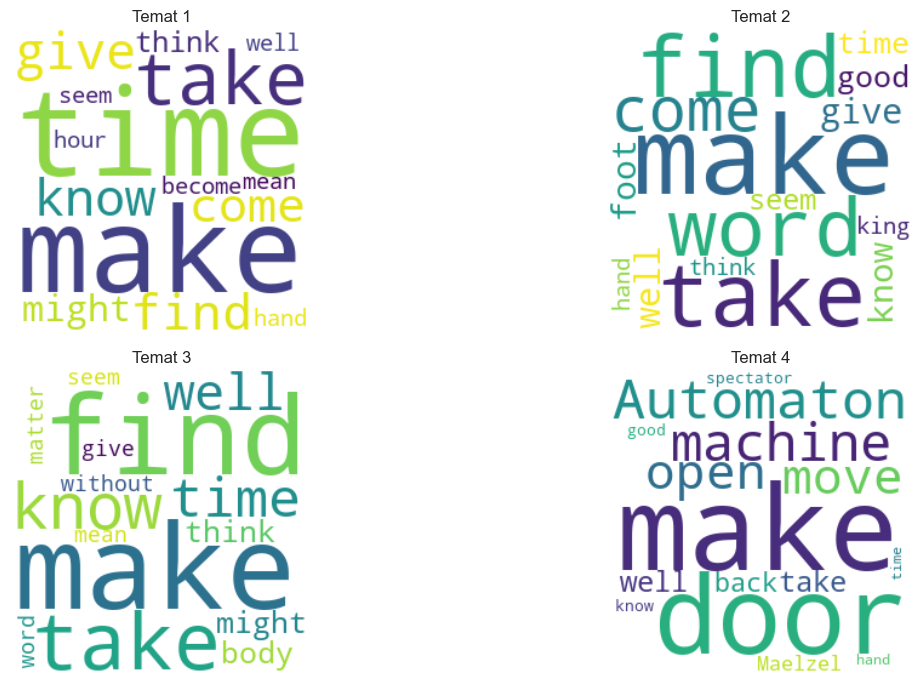

In [9]:
texts = list(lemmatized_corpus.values())
dictionary = corpora.Dictionary(texts)
corpus_gensim = [dictionary.doc2bow(text) for text in texts]

# Trening modelu LDA
lda_model = gensim.models.LdaModel(corpus_gensim, num_topics=4, id2word=dictionary, passes=100)

# Wizualizacja tematów jako chmury słów
def plot_word_clouds(lda_model, num_topics, num_words=15):
    fig, axes = plt.subplots(num_topics//2, 2, figsize=(15, 7), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        wordcloud = WordCloud(background_color='white', width=250, height=250, max_words=num_words).generate_from_frequencies(dict(lda_model.show_topic(i, num_words)))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Temat {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_word_clouds(lda_model, num_topics=4)

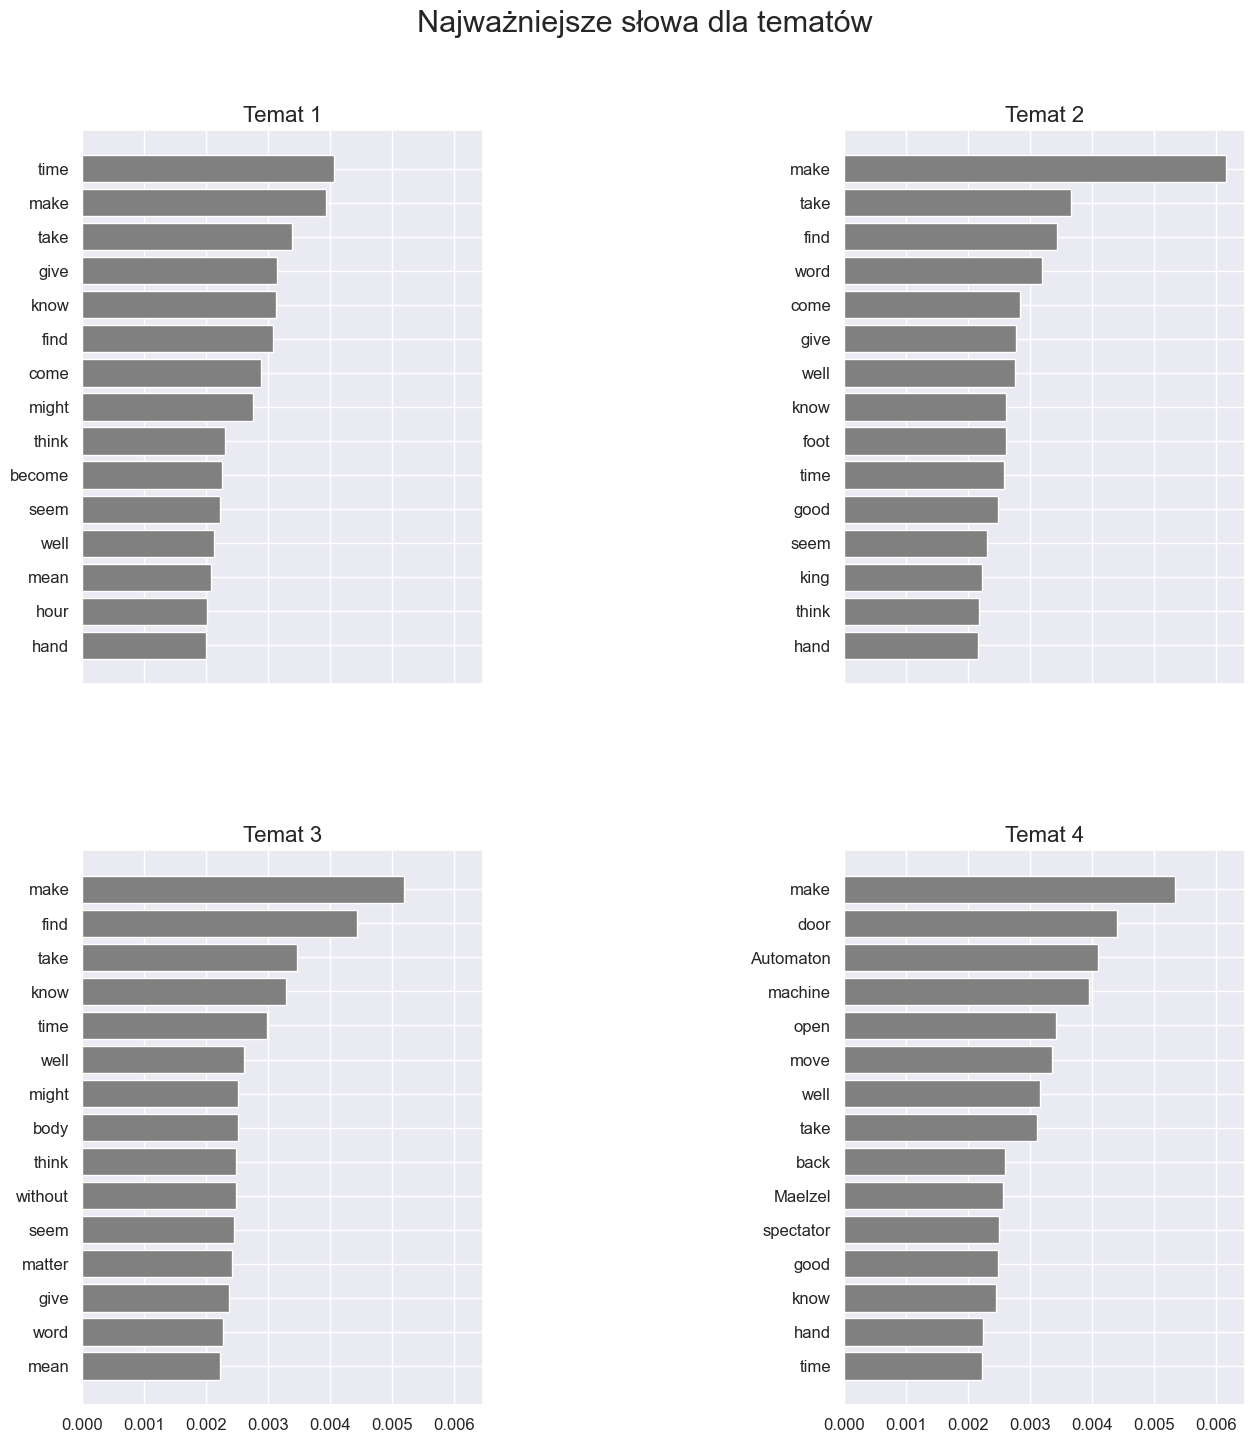

In [10]:
 # Funkcja do stworzenia wykresów kolumnowych
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.show_topics(num_topics=4, num_words=n_top_words, formatted=False)):
        top_words = dict(topic[1])
        ax = axes[topic_idx]
        ax.barh(list(top_words.keys()), list(top_words.values()), color='grey')
        ax.set_title(f'Temat {topic_idx + 1}', fontsize=16)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
    plt.suptitle(title, fontsize=22)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda_model, dictionary, 15, 'Najważniejsze słowa dla tematów')